# Perdicting Credit Card Fraud using Perdictive Modeling

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, OrdinalEncoder

from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt

from scipy.stats import zscore

## I. Data Wrangling 

### Subsetting the initial dataset

As the original dataset contained over a million observations I could not load it into github. Instead I loaded it in from my own machine and subsetted the data set to a proportionate size. This function should not be called again but was kept to show this unique component of data wrangling.

In [2]:
def make_subset():
    train = pd.read_csv(r"C:\Users\97mko\Documents\fraudTrain.csv")
    train_subset = train.sample(n = 75000, random_state = 97)
    train_subset.to_csv('FraudTrainRandomSubset97.csv');
    
    test = pd.read_csv(r"C:\Users\97mko\Documents\fraudTest.csv")    
    test_subset = test.sample(n = 25000, random_state = 97)
    test_subset.to_csv('FraudTestRandomSubset97.csv');

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/InqM/BuildWeek2/main/FraudTrainRandomSubset97.csv")

def wrangle(df):
    
    #Converting time of transaction to index transaction time will be used for a later feature.
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%Y-%m-%d')
    df.index = df['trans_date_trans_time']
    
    #Dropping non distinct columns:
    df = df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'trans_num', 'unix_time'])
    
    #A feature that has age from dob and transaction date time:
    df['dob'] = pd.to_datetime(df['dob'], format='%Y-%m-%d')
    df['age'] = df.apply(lambda x: relativedelta(x.trans_date_trans_time, x.dob), axis=1).apply(lambda x: x.years)
    df = df.drop(columns = ['dob', 'trans_date_trans_time'])
    
    #Dropping columns that are either redundant or close to being so:
    #First Last and cc_num will be represented by street while city will be represented by zip.
    df = df.drop(columns = ['first', 'last', 'cc_num', 'city'])
    
    #Converting categorical int values into objects.
    df['zip'] = df['zip'].astype('object')
    
    return df
    
df = wrangle(df)

As a side note I would like to mention that as this dataset was generated through a github simulation and also by virtue of how this information may be generated naturally there are no missing values. Additionally none of the features I have been giving would suggest causing data leakage.

## II. Split Data
My target column was an easy decision. As I am trying to determine credit card fraud I am using the "is_fraud" column. This would be a classification problem as there is only two categories determining whether or not the category is fraud.

In [4]:
X = df.drop(columns = 'is_fraud')
y = df['is_fraud']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## III. Establish Baseline

In [5]:
baseline_acc = df['is_fraud'].value_counts()[0]/df['is_fraud'].size
print('Baseline Accuracy:', str(baseline_acc))

Baseline accuracy: 0.99468


## IV. Building Models

### Random Forest Model
This is ultimately the model I decided to stick with not only due to a better performance but also as it runs much faster that the linear regression model. To improve at after my initial test I added additional estimators.

In [6]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_estimators = 50,
                           random_state = 42,
                           n_jobs = -1)
)

model_rf.fit(X_train, y_train);

### Logistic Regression Model
A note for this model is that the Logistic Regression function has a default max iteration of 100. At this number my model would however reach that cap and consequently produce an error message so I had increased it to 1000. I am not sure the exact number needed and I did not look into it as this is the model I did not end up using this model.

In [7]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    StandardScaler(),    
    LogisticRegression(random_state = 42, max_iter = 1000)
)

model_lr.fit(X_train, y_train);

c:\users\97mko\.virtualenvs\ds-unit-2-applied-modeling-kpfik8dc\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## V. Check Metrics

### Accuracy Score


In [15]:
print('Random Forest Training Accuracy:', model_rf.score(X_train, y_train))
print('Random Forest Validation Accuracy:', model_rf.score(X_val, y_val))
print('Logistic Regression Training Accuracy:', model_lr.score(X_train, y_train))
print('Logistic Regression Validation Accuracy:', model_lr.score(X_val, y_val))

Training Accuracy (RF): 0.9999833333333333
Validation Accuracy (RF): 0.9968666666666667
Training Accuracy (LOGR): 0.9971833333333333
Validation Accuracy (LOGR): 0.9937333333333334


Initially and perhaps out of habit I immediately went to test the accuracy to make sure it beat the baseline. Only the Random Forest Model surpassed the baseline however the importance of this score comes secondary to the recall score...

### Recall Score 

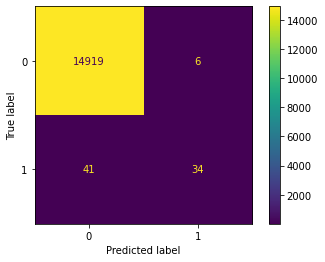

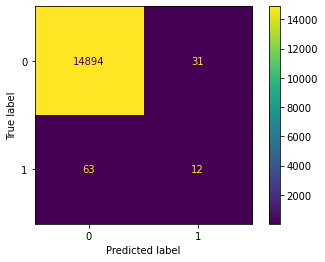

In [9]:
plot_confusion_matrix(model_rf, X_val, y_val);
plot_confusion_matrix(model_lr, X_val, y_val);

As a false a positive is more important to detect we divide the correct perdictions of this by the incorrect perdictions.

In [19]:
print('Random Forest Recall Score:', str(34/(41+34)))
print('Logestic Regression Recall Score:', str(12/(63+12)))

Random Forest Recall Score: 0.4533333333333333
Logestic Regression Recall Score: 0.16


Once again the Random Forest out preforms the Linear Regression and as the latter model also takes longer to execute from here on out I will use the test set on my Random Forest model and try to focus on improving that one.


Test Accuracy (RF): 0.99744


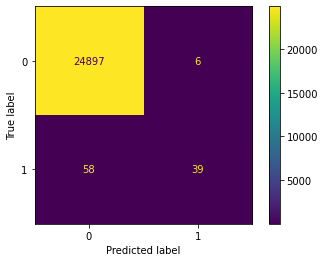

In [16]:
test = pd.read_csv("https://raw.githubusercontent.com/InqM/BuildWeek2/main/FraudTestRandomSubset97.csv")
test = wrangle(test)
X_test = test.drop(columns = 'is_fraud')
y_test = test['is_fraud']
print('Test Accuracy (RF):', model_rf.score(X_test, y_test))
plot_confusion_matrix(model_rf, X_test, y_test);

In [20]:
print('Test Recall Score:', str(39/(58+39)))

Test Recall Score: 0.4020618556701031


As a solution to a real world problem I would not consider a recall score of 40% to be an effective model as false positives are highly preferable to false negatives.

### Feature Importances 
As there are in total 14 features in my model I decide not to display the top N features as it would be easy to read every category and as shown below I find that each category does have some level of feature importances

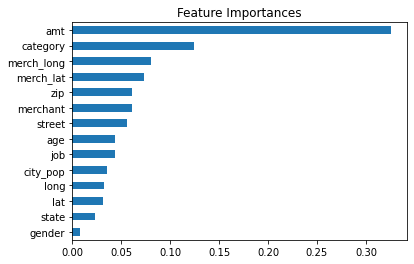

In [12]:
importances = pd.Series(model_rf.steps[1][1].feature_importances_, X.columns).sort_values(ascending = True)
plt.figure
plt.title(f'Feature Importances')
importances.plot.barh();

### Addition Feature Engineering
While my model may be ineffective in its current state I am not satisfied with this conclusion and attempt to generate additional features in order to hopefully improve model performance.

In [22]:
def add_features(df):
    #Evaluating zscore in order to determine outliers of amount.
    df['is_outlier'] = zscore(df['amt']) > 3
    return df

df = add_features(df)

In [25]:
outlier_vs_fraud = pd.crosstab(df['is_outlier'], df['is_fraud'], margins = True)

#This multiplication and division is used to convert the crosstab into a percentage.
outlier_vs_fraud = outlier_vs_fraud/outlier_vs_fraud.sum()*100

outlier_vs_fraud

is_fraud,0,1,All
is_outlier,,,
False,49.631372,26.315789,49.507333
True,0.368628,23.684211,0.492667
All,50.000000,50.000000,50.000000


In [33]:
outlier_vs_fraud = pd.crosstab(test['is_outlier'], test['is_fraud'], margins = True)

#This multiplication and division is used to convert the crosstab into a percentage.
outlier_vs_fraud = outlier_vs_fraud/outlier_vs_fraud.sum()*100

outlier_vs_fraud

is_fraud,0,1,All
is_outlier,,,
False,49.50006,26.28866,49.41
True,0.49994,23.71134,0.59
All,50.00000,50.00000,50.00


The above crosstab shows that an outlier in amount has a very large correlation with the presence of fraud. This feature alone would produce an accuracy on both the training and then the test set of over 47% better than my current model.

c:\users\97mko\.virtualenvs\ds-unit-2-applied-modeling-kpfik8dc\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\users\97mko\.virtualenvs\ds-unit-2-applied-modeling-kpfik8dc\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


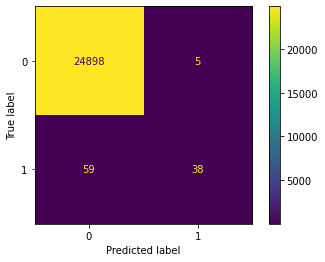

In [30]:
#Split the data with the new feature
X = df.drop(columns = 'is_fraud')
y = df['is_fraud']

model_rf.fit(X_train, y_train);
#Refit the model
model_rf.fit(X, y);

#Add the feature to the test data and split
test = add_features(test)
X_test = test.drop(columns = 'is_fraud')
y_test = test['is_fraud']

#Report the results
plot_confusion_matrix(model_rf, X_test, y_test);

This does not improve the model actually making it slightly worse possibly due to the large number of other features. 